In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

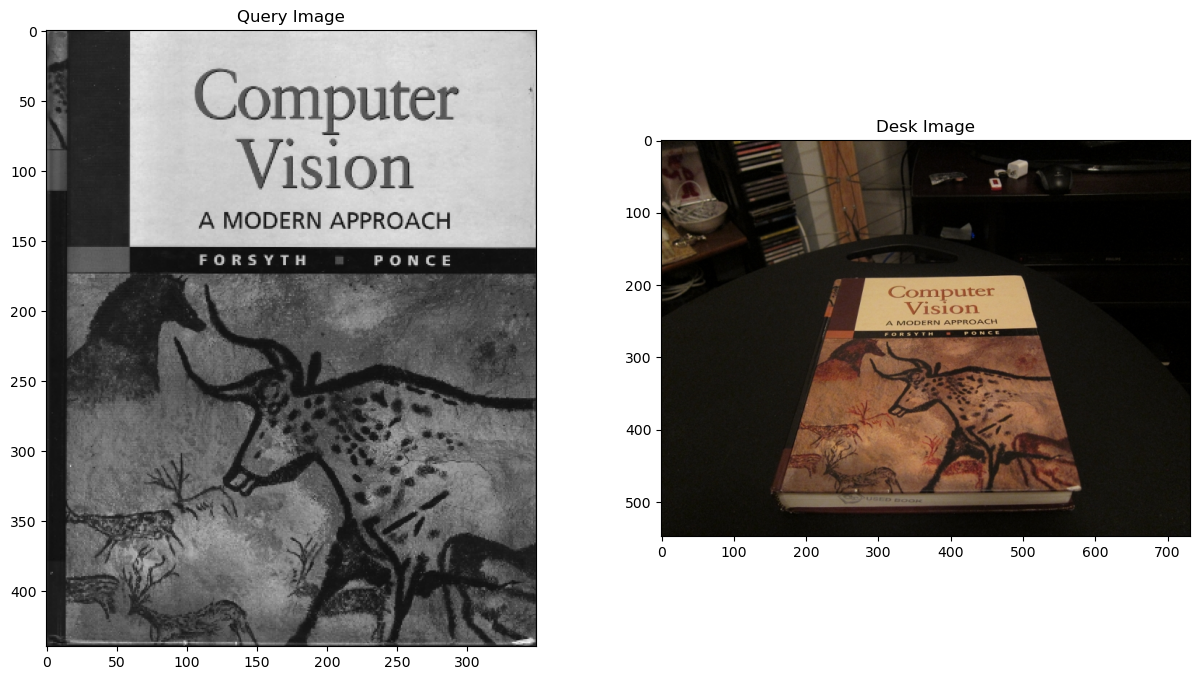

In [4]:
queryImage = 'cv_cover.jpg'
trainImage = 'cv_desk.png'

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(queryImage), cv2.COLOR_BGR2RGB))
plt.title('Query Image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread(trainImage), cv2.COLOR_BGR2RGB))
plt.title('Desk Image')
plt.show()

img1 = cv2.imread(queryImage, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(trainImage, cv2.IMREAD_GRAYSCALE)

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create()

In [7]:
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [10]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

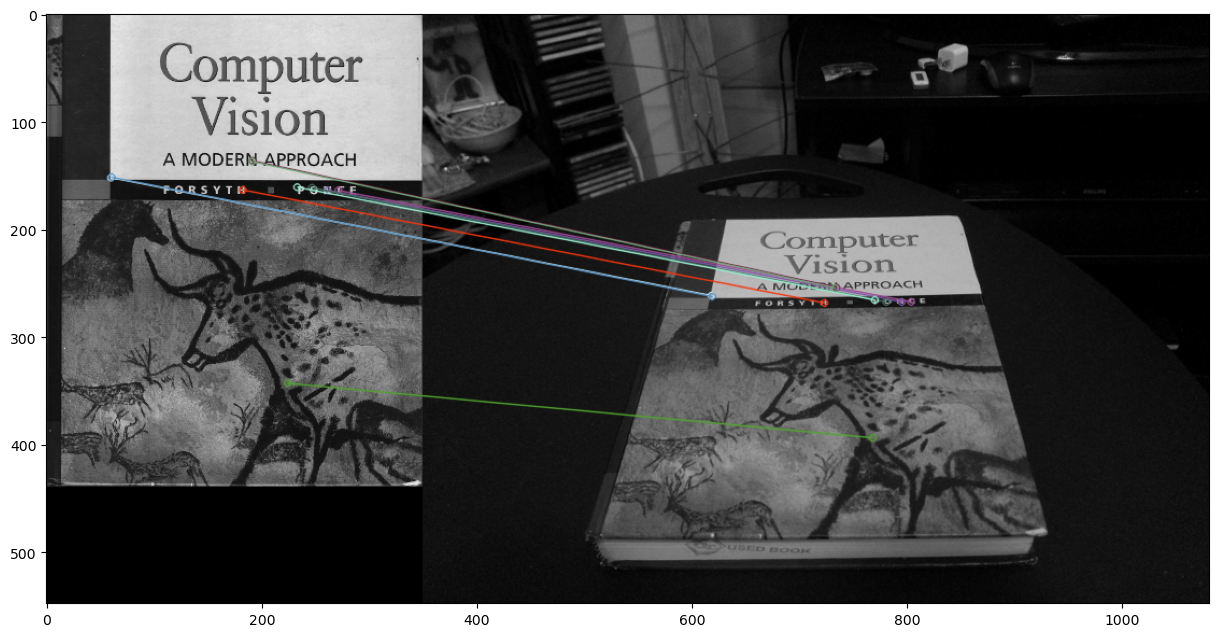

In [13]:
# Draw first 10 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(img3)
plt.show()

### Find homography and warping

In [14]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
    
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

height, width = img2.shape

im1_warped = cv2.warpPerspective(img1, h, (width, height))

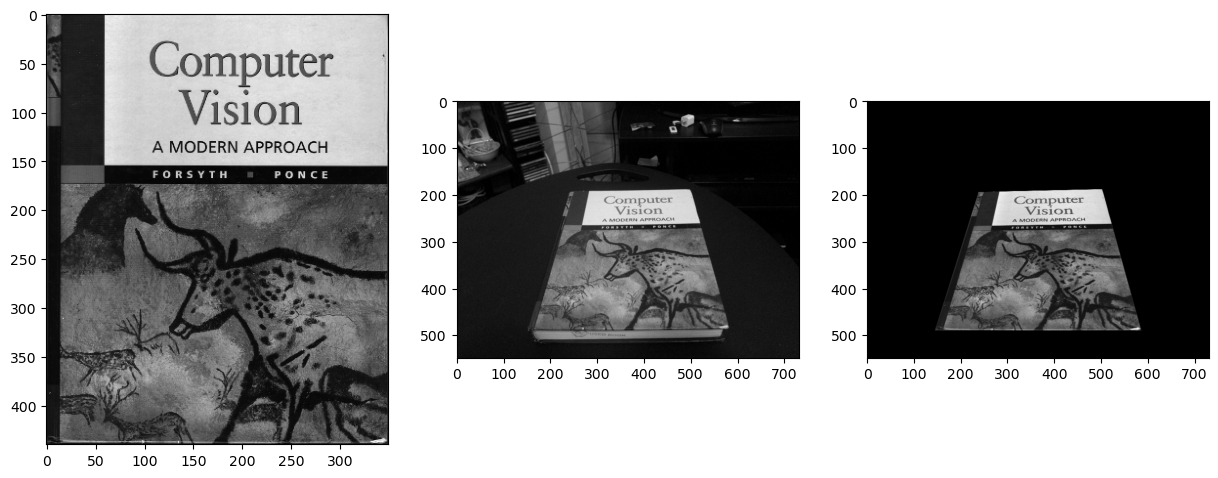

In [15]:
plt.figure(figsize=(15, 8))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im1_warped, cmap='gray')
plt.show()

### Brute Force Matching with SIFT Descriptors and Ratio Test

- get k best matches

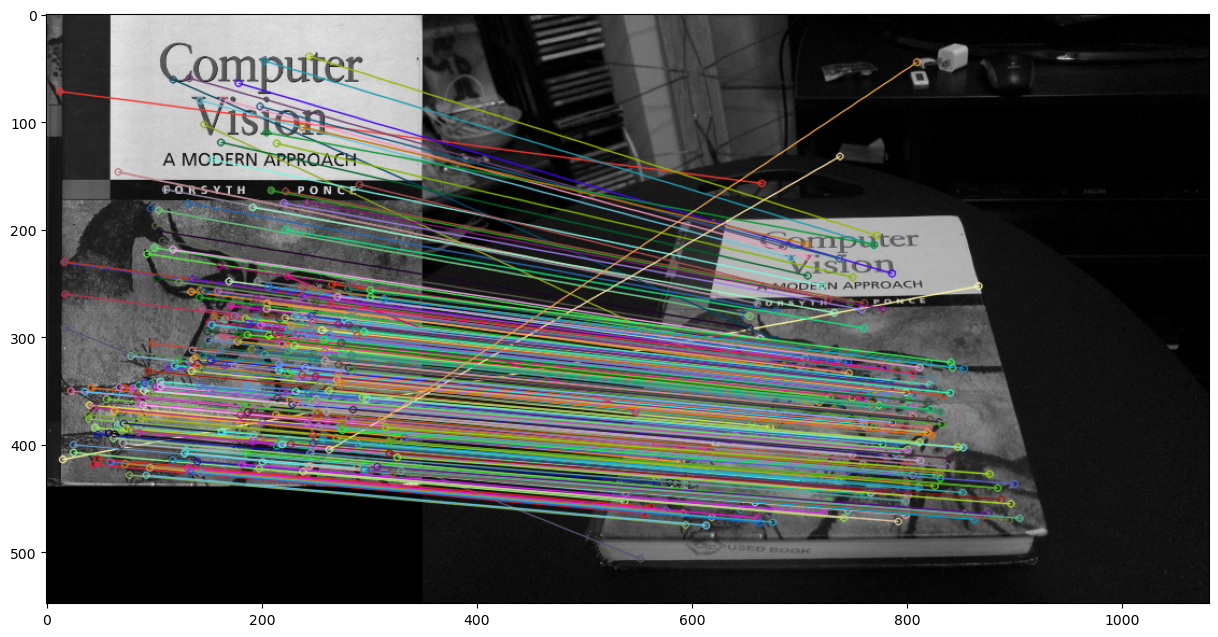

In [17]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
## 애매한 matching score를 비교. threshold를 지정해 drop하는 방식
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv2.drawMatchesKnn expects list of lists as matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(img3)
plt.show()